In [1]:
import networkx as nx
import csv
from collections import defaultdict
from itertools import combinations
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook
DATA_DIR = "../final/"

def csv_read(filename):
    with open(op.join(DATA_DIR,filename)) as fh:
        yield from csv.DictReader(fh)

def build_complaint_graph():
    # build a dictionary mapping a complaint_no to set of UIDs of officers
    # listed in the complaint
    complaints_officers = defaultdict(set)
    for row in csv_read("complaints_officers.csv"):
        complaints_officers[row["complaint_no"]].add(row["uid"])

    g = nx.Graph()
    for complaint_no, officers in complaints_officers.items():
        # add an edge for each pair of officers appearing in a given complaint
        for pair in combinations(officers,2):
            g.add_edge(*pair)
    return g

In [2]:
g = build_complaint_graph()
trrs= pd.read_csv('../final/tactical_response_reports.csv')
uids = set(trrs['uid'])
no_uids = [node for node in g.nodes if node not in uids]
g_trrs = g.subgraph(uids)
g_not_trrs = g.subgraph(no_uids)

In [3]:
### BASIC GRAPH STATS
edges = g.number_of_edges()
degs = nx.degree_histogram(g) # DEGREE DISTRIBUTION
average_degree = np.inner(np.arange(len(degs)), degs)/np.sum(degs) # AVERAGE DEGREE
triangles = np.sum(list(nx.triangles(g).values()))/3
clique_number = nx.graph_clique_number(g) # SIZE OF LARGEST CLIQUE
connected_components = [g.subgraph(c).copy() for c in nx.connected_components(g)] # NUMBER AND SIZES OF  CONNECTED COMPONENTS
sizes_connected_components = -np.sort([-len(c.nodes) for c in connected_components])

edges_trrs = g_trrs.number_of_edges()
degs_trrs = nx.degree_histogram(g_trrs)
average_degree_trrs = np.inner(np.arange(len(degs_trrs)), degs_trrs)/np.sum(degs_trrs)
clique_number_trr = nx.graph_clique_number(g_trrs)
triangles_trr = np.sum(list(nx.triangles(g_trrs).values()))/3
connected_components_trrs = [g_trrs.subgraph(c).copy() for c in nx.connected_components(g_trrs)]
sizes_connected_components_trrs = -np.sort([-len(c.nodes) for c in connected_components_trrs]) 


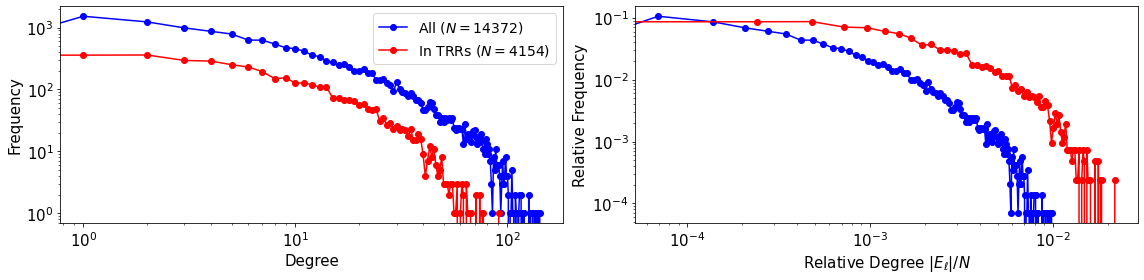

In [4]:
degree_freq = nx.degree_histogram(g)
degree_freq_trrs = nx.degree_histogram(g_trrs)

degrees = range(len(degree_freq))
degrees_trrs = range(len(degree_freq_trrs))

plt.figure(figsize=(16, 4)) 
plt.subplot(121)

plt.loglog(degrees, degree_freq,'go-', color = 'b', label = r'All ($N= $'+str(len(g.nodes))+r'$)$') 
plt.loglog(degrees_trrs, degree_freq_trrs,'go-', color = 'r', label = r'In TRRs ($N= $'+str(len(g_trrs.nodes))+r'$)$') 

plt.xlabel('Degree', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 14)
plt.subplot(122)

plt.plot(np.array(degrees)/len(g.nodes), degree_freq/np.array(degree_freq).sum(),'go-', color = 'b') 
plt.plot(np.array(degrees_trrs)/len(g_trrs.nodes), degree_freq_trrs/np.array(degree_freq_trrs).sum(),'go-', color = 'r') 

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Relative Degree $|E_\ell|/N$', fontsize = 15)
plt.ylabel('Relative Frequency', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.tight_layout()
plt.savefig('../doc/figs/degree_distribution.pdf', dpi = 1000, bbox_inches = 'tight')

plt.show()

In [5]:
# distribution of avg connected intrashooting time  vs  aany intrashooting time?

def read_shootings(trrs, list_of_uids=None):
    '''
        Input:
            trrs<dict>:
                keys: trr_id
                values: trr_info 
            list_of_uids<list>, optional
                filter down shootings by officer_ids
        Output:
            shootings<dict>:
                keys: shoooting id
                values: officers unique ids
            officer_shootings:
                keys: officer unique id
                values: shooting times at which officer has shot
                
    '''
    assert type(trrs) == dict, 'Input must be a dictionary of trrs, in which keys are trrs numbers and values the associated sed of officers involved'
    shootings = defaultdict(dict)
    officer_shootings = defaultdict(list)
    
    for trr_id, item in trrs.items():
        shooting_id = item['event_no']
        officer_id = item['uid']
        if (list_of_uids == None) or (officer_id in list_of_uids):
            item['date'] = pd.to_datetime(item['date'])
            shootings[shooting_id][officer_id] = item
            officer_shootings[officer_id].append(item['date'])
        
    # sorts the shooting dates for each officer
    for shooting_list in officer_shootings.values():
        shooting_list.sort()
    return shootings, officer_shootings

# trrs_ = pd.read_csv('../final/tactical_response_reports.csv')
start_date = pd.to_datetime('2004-01-01') # START OF STUDY PERIOD
end_date = pd.to_datetime('2015-12-01') # END OF STUDY PERIOD
trrs = {}
for row in csv_read('../final/tactical_response_reports.csv'):
    shooting_date = pd.to_datetime(row['date'])
    if shooting_date - start_date > pd.to_timedelta(0) and end_date-shooting_date > pd.to_timedelta(0) and row['uid'] in g.nodes:
        trrs[row["trr_id"]] = row
shootings, officers_shootings = read_shootings(trrs)

In [6]:
# officers_shootings
list_ = []
for officer, shootings_ in tqdm_notebook(officers_shootings.items()):
    for shooting in shootings_:
        list_.append([officer, pd.to_datetime(shooting)])

<ipython-input-6-03f4a4d4cd13>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for officer, shootings_ in tqdm_notebook(officers_shootings.items()):


  0%|          | 0/4105 [00:00<?, ?it/s]

In [ ]:
connected = [0,0]
time_range = end_date-start_date
delta_time_connected = np.zeros(time_range.days)
delta_time_disconnected = np.zeros(time_range.days)
for e_a, event_a in tqdm_notebook(enumerate(list_)):
    uid_a, time_a = event_a
    for event_b in list_[e_a+1:]:
        uid_b, time_b = event_b
        is_connected = uid_b in g.neighbors(uid_a)
        connected[is_connected] += 1
        delta_time_ = time_a-time_b
        if is_connected:
            delta_time_connected[delta_time_.days] += 1
        else:
            delta_time_disconnected[delta_time_.days] += 1

# np.save('../../derived_data/delta_time_network_disconnected', delta_time_disconnected)
# np.save('../../derived_data/delta_time_network_connected', delta_time_connected)
# np.save('../../derived_data/connected', connected)

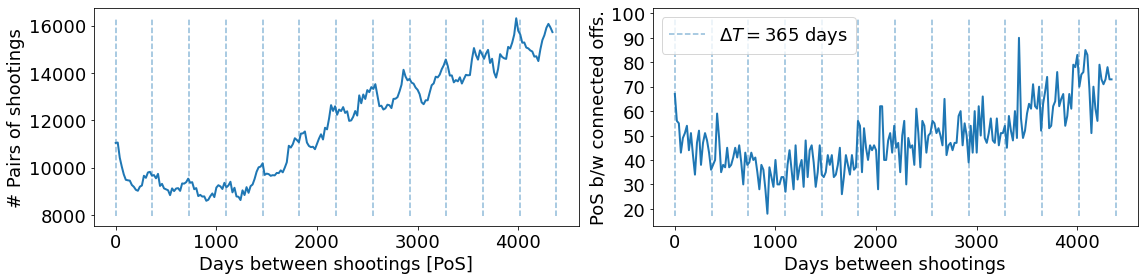

In [17]:
plt.figure(figsize = (16,4))

delta_time_disconnected = np.load('../../derived_data/delta_time_network_disconnected.npy')
delta_time_disconnected = delta_time_disconnected[1:]

delta_time_connected = np.load('../../derived_data/delta_time_network_connected.npy')
delta_time_connected = delta_time_connected[1:]

delta_time_all = (delta_time_disconnected+delta_time_connected) #/(delta_time_disconnected+delta_time_connected).sum()

plt.subplot(121)
plt.plot(np.arange(len(delta_time_all))[::20], delta_time_all[::20], lw = 2)
plt.vlines(x = 365*np.arange(13), ymin = .95*min(delta_time_disconnected)*np.ones(13), ymax = max(delta_time_disconnected)*np.ones(13), alpha = .5, linestyle = '--')
plt.xticks(fontsize = 18)
plt.xlabel('Days between shootings [PoS]', fontsize = 18)
plt.ylabel('# Pairs of shootings', fontsize = 18)
plt.yticks(fontsize = 18)
plt.subplot(122)
plt.plot(np.arange(len(delta_time_connected))[::20], delta_time_connected[::20], lw = 2)
plt.vlines(x = 365*np.arange(13), ymin = .95*min(delta_time_connected)*np.ones(13), ymax = max(delta_time_connected)*np.ones(13), alpha = .5, label = r'$\Delta T= 365$ days', linestyle = '--')
plt.ylabel('PoS b/w connected offs.', fontsize = 18)
plt.xlabel('Days between shootings', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 18)
plt.tight_layout()
plt.savefig('../doc/figs/intrashooting_times.pdf', bbox_inches = 'tight', dpi = 1000)